In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the aggregated data
X = pd.read_csv('input_data/processed/aggregated_data_001.csv')
print(X.shape)

(1308050, 19)


In [3]:
X.columns

Index(['FIRE_ID', 'LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'OBLAST_ID',
       'GRID_CELL', 'DAY_OF_YEAR', 'FIRE_COUNT_CELL', 'FIRE_COUNT_OBLAST',
       'FIRE_COUNT_CELL_AVG_7D', 'FIRE_COUNT_OBLAST_AVG_7D',
       'FIRE_COUNT_CELL_AVG_30D', 'FIRE_COUNT_OBLAST_AVG_30D',
       'POP_DENSITY_CELL_AVG', 'LAND_USE_CLASS_1', 'LAND_USE_CLASS_2',
       'LAND_USE_CLASS_3', 'LAND_USE_CLASS_4'],
      dtype='object')

In [4]:
# We want to use plot the data later, thus we need to copy the original values of the temporal and spatial features and the fire IDs
temporal_spatial_features = ['FIRE_ID', 'ACQ_DATE', 'DAY_OF_YEAR', 'LATITUDE', 'LONGITUDE']
X_ts = X[temporal_spatial_features].copy()
X_ts.head()

,FIRE_ID,ACQ_DATE,DAY_OF_YEAR,LATITUDE,LONGITUDE
0,921182,2015-01-01,1,47.09,37.61
1,921184,2015-01-01,1,47.09,37.61
2,921183,2015-01-01,1,47.09,37.61
3,921181,2015-01-01,1,47.15,37.53
4,921185,2015-01-02,2,50.51,28.74


In [5]:
# Lets define which columns to keep
columns_to_keep = [
    'ACQ_DATE',
    'LATITUDE', 
    'LONGITUDE', 
    'DAY_OF_YEAR', 
    'FIRE_COUNT_CELL', 
    'FIRE_COUNT_CELL_AVG_7D',
    'FIRE_COUNT_CELL_AVG_30D',
    'FIRE_COUNT_OBLAST',
    'FIRE_COUNT_OBLAST_AVG_7D',
    'FIRE_COUNT_OBLAST_AVG_30D',
    'POP_DENSITY_CELL_AVG',
    'LAND_USE_CLASS_1',
    'LAND_USE_CLASS_2',
    'LAND_USE_CLASS_3',
    'LAND_USE_CLASS_4',
    ]
# Drop the columns that we don't need
X = X.drop(columns=set(X.columns) - set(columns_to_keep))
X.shape

(1308050, 15)

In [6]:
# Get the data for those rows with ACQ_DATE smaller than 2022-02-24 (the first day of the UKR war)
# and for those rows with ACQ_DATE greater than 2022-02-24

# Data before the war
X_pre = X[X['ACQ_DATE'] < '2022-02-24']
X_ts_pre = X_ts[X['ACQ_DATE'] < '2022-02-24']
X_pre.drop(columns=['ACQ_DATE'], inplace=True)

X_pre.shape

(896367, 14)

In [7]:
# Lets transform the data so that we can use it for clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_pre)
X_pre_scaled = scaler.transform(X_pre)

X_pre_scaled = pd.DataFrame(X_pre_scaled, columns=X_pre.columns)
X_pre_scaled.head()

,LATITUDE,LONGITUDE,DAY_OF_YEAR,FIRE_COUNT_CELL,FIRE_COUNT_OBLAST,FIRE_COUNT_CELL_AVG_7D,FIRE_COUNT_OBLAST_AVG_7D,FIRE_COUNT_CELL_AVG_30D,FIRE_COUNT_OBLAST_AVG_30D,POP_DENSITY_CELL_AVG,LAND_USE_CLASS_1,LAND_USE_CLASS_2,LAND_USE_CLASS_3,LAND_USE_CLASS_4
0,-1.087270,1.168188,-2.434418,0.516762,-0.979767,-0.161225,-0.951214,0.899824,-0.961419,2.054218,-0.286956,-0.345282,0.658513,-0.363323
1,-1.087270,1.168188,-2.434418,0.516762,-0.979767,-0.068254,-0.956203,0.886693,-0.962588,2.054218,-0.286956,-0.345282,0.658513,-0.363323
2,-1.087270,1.168188,-2.434418,0.516762,-0.979767,0.024716,-0.961192,0.874757,-0.963757,2.054218,-0.286956,-0.345282,0.658513,-0.363323
3,-1.048173,1.149366,-2.434418,-0.673332,-0.979767,-0.719045,-0.966181,-0.754625,-0.964927,2.054218,-0.286956,-0.345282,0.658513,-0.363323
4,1.141215,-0.918662,-2.421335,-0.673332,-1.000693,-0.719045,-0.993123,-0.754625,-0.983837,-0.511679,-0.286956,-0.345282,0.658513,-0.363323


In [8]:
# Now lets apply PCA to reduce the dimensionality of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_pre_pca = pca.fit_transform(X_pre_scaled)

X_pre_pca = pd.DataFrame(X_pre_pca)
X_pre_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.374959,1.340125,0.023832,-0.700548,-0.665593,-1.824658,-2.500547,-0.633400,1.460238,-0.052238
1,-1.351500,1.375140,0.043223,-0.706143,-0.668156,-1.828080,-2.506011,-0.634814,1.459762,-0.066945
2,-1.327659,1.410653,0.062874,-0.711829,-0.670755,-1.831545,-2.511538,-0.636244,1.459280,-0.082305
3,-2.473470,-0.054122,-0.696804,-0.409604,-0.564782,-1.702680,-2.282596,-0.554315,1.478698,0.025888
4,-1.607116,-1.038983,1.043747,1.884137,-0.669353,-1.976050,-0.879053,0.187224,-0.264534,0.031801


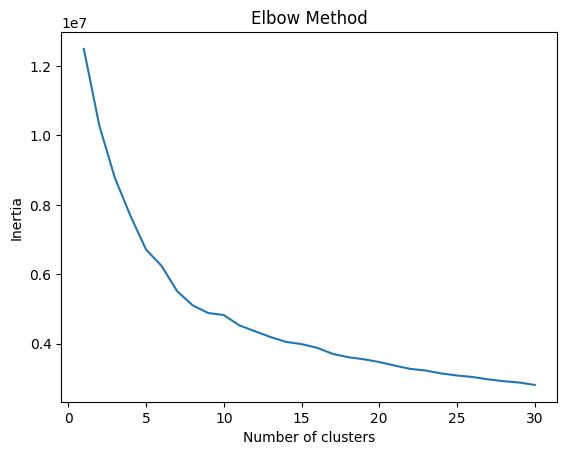

In [9]:
# Find the optimal number of clusters using the elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pre_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 31), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [10]:
# Use a clustering algorithm where I can specify the number of clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans.fit(X_pre_pca)

# Get the labels of the clusters
y_labels = kmeans.labels_

# Get the size of each cluster
cluster_sizes = pd.Series(kmeans.labels_).value_counts()
cluster_sizes

7    196437
0    139171
3    110717
2    105224
8     85984
6     79447
1     73745
9     59193
5     24949
4     21500
Name: count, dtype: int64

In [11]:
# Save the cluster labels to a file
cluster_labels = pd.DataFrame({'FIRE_ID': X_ts_pre['FIRE_ID'], 'CLUSTER_LABEL': y_labels})
cluster_labels.to_csv('output_data/cluster_labels_pre_war.csv', index=False)

In [12]:
# Save the scaler and pca objects
import pickle

with open('saved_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('saved_models/pca.pkl', 'wb') as f:
    pickle.dump(pca, f)